## CyclePainter version 3

In [1]:
# calling twice allegedly avoids some possible bugs
%matplotlib notebook
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from matplotlib.widgets import RadioButtons, Button

In [2]:
# abelfunctions
from abelfunctions import *
from abelfunctions.complex_path import ComplexLine
from abelfunctions.utilities import Permutation

In [3]:
from time import clock

In [4]:
R.<x,y> = QQ[]

In [105]:
class CyclePainter():
    '''
    DESCRIPTION:
    
    METHODS:
    
    
    '''
    
    def __init__(self, surface=None, monodromy_base_point=None, pc=None, kappa=1./5.):
        '''
            PARAMETERS
                surface:              Expression for the underlying Riemann surface, e.g. '-x^2 + y^6 + 5*y^3 + 1'
                monodromy_base_point: Base point for calculating the monodromy in abelfunctions :: complex
                                      (RECOMMENDED chosen to the left of every branch point)
                pc:                   The center of the star-shaped CyclePainter's cuts :: complex
                                      (if not provided, found algorithmically)
                kappa:                The radius of the "avoidance" of problematic points. The smaller,
                                      the less restricted (but with worse performance) the analytic continuation is.
                                        :: real in (0, 1)
        '''
        ###################
        #                initialize the main global variables
        ###################
        
        self.surface = surface # the equation of the Riemann Surface
        self.rs = RiemannSurface(surface, base_point=monodromy_base_point, kappa=kappa)
        self.sheets = self.rs.degree # the number of sheets
        self.base_sheets = self.rs.base_sheets # the values of sheets at the (monodromy) base point
        
        self.PATHS = []     # will store saved paths
        self.log = []       # for miscellaneous logging
        self.counter = 0    # global counter of added points on the plot
        self.paused = False # for handling the Pause/Continue button
        #                     drawing_state will be throughout the execution one of:
        #                        -'idle': not responding to any clicks
        #                        -'start_draw': ready for the first point of a new path
        #                        -'drawing': in the process of creating a path
        #                        -'finish_draw': the path has been completed
        self.drawing_state = 'idle'
        
        self.current_sheet = 1          # store the current sheet when building a path
        self.start_sheet = 1            # store the radio button value
        self.current_path = []          # store the path currently being built
        self.current_path_scatters = [] # for the scatter plots of the path currently being built
        
        ###################
        #                Compute data about branch points & their permutations
        ###################
        

        # obtain the branch points / permutations as computed by abelfunctions
        self.branch_points, abel_branch_permutations = self.rs.monodromy_group()
        
        # we need numerical approximation of the branch points
        for i in range(len(self.branch_points)):
            if self.branch_points[i] != +Infinity:
                self.branch_points[i] = self.branch_points[i].n()
                
        # colors of sheets sampled from the rainbow color distribution
        self.sheet_color_map = dict(enumerate(plt.cm.rainbow(np.linspace(0, 1, self.sheets)), 1))
        
        # is infinity a branch point?
        self.has_infty = +Infinity in self.branch_points
        
        # finite branch points
        self.fin_branch_points = list(filter(lambda x: x != +Infinity, self.branch_points))
        self.branch_real_parts = map(lambda x: x.real(), self.fin_branch_points)
        self.branch_imag_parts = map(lambda x: x.imag(), self.fin_branch_points)
        
        # variables describing the scale in which we are working
        self.real_span = max(self.branch_real_parts) - min(self.branch_real_parts)
        self.imag_span = max(self.branch_imag_parts) - min(self.branch_imag_parts)
        self.real_span = 1 if self.real_span == 0 else self.real_span
        self.imag_span = 1 if self.imag_span == 0 else self.imag_span
        # minimal distance between any two branch points
        self.min_distance = min((self.fin_branch_points[i] - x).abs()
                                for i in range(len(self.fin_branch_points)) for x in self.fin_branch_points[:i])
        
        # computer the center of the CyclePainter cuts
        self.pc = pc if pc else self._find_pc()
        
        # update rs with a new base-point
        self.rs = self.rs = RiemannSurface(surface, base_point=np.complex(np.real(self.rs.base_point)+I*self.pc.imag()), kappa=kappa)
        
        # obtain the branch points / permutations as computed by abelfunctions
        self.branch_points, abel_branch_permutations = self.rs.monodromy_group()
        
        # transform the branch permutations from abelfunctions into ones that will be used in CyclePainter
        # (we need permutations whose monodromy paths are consistent with the cuts of CyclePainter)
        self.branch_permutations = self._compute_branch_permutations(abel_branch_permutations)
    
    def show_branch_permutations(self):
        ''' Shows the information about the branch permutations. '''
        for n, perm in enumerate(self.branch_permutations, 1):
            permrep = ''
            for c in eval(str(perm)):
                permrep = str(tuple(map(lambda x: x+1, c))).replace(',', '') + ' ' +  permrep
            print('Branch point #{:d}: {:s}'.format(n, permrep))
            print('    value: {:s}'.format(str(self.branch_points[n-1])))
    
    def dist(self, p1, p2):
        ''' UTILITY method for euclidean distance'''
        return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5
    
    def ccw(self, a, b, c):
        ''' UTILITY method for determining orientation '''
        return bool((c[1] - a[1]) * (b[0] - a[0]) > (b[1] - a[1]) * (c[0] - a[0]))

    def intersect(self, a, b, c, d):
        ''' UTILITY method to check if two *line segments* intersect '''
        return bool(self.ccw(a, c, d) != self.ccw(b, c, d) and self.ccw(a, b, c) != self.ccw(a, b, d))

    def intersection(self, (x1, y1), (x2, y2), (x3, y3), (x4, y4)):
        ''' UTILITY method to find the intersection point of X1X2 and X3X3 '''
        px = float((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4))
        d = float((x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4))
        py = float((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4))
        return (px/d, py/d)
    
    def _compute_branch_permutations(self, abelfunctions_m):
        ''' m - the monodromy permutations given by abelfunctions '''
        # by the choice of pc, there should be no branch points on the line
        # defined by pc and the monodromy base point.
        eps = 10**(-9)
    
        # divide the branch points into three categories
        left, right = [], [] # and infinity
        for i in range(len(self.branch_points)):
            if self.branch_points[i] == +Infinity:
                continue
            if not self.ccw((np.real(self.rs.base_point), np.imag(self.rs.base_point)), (self.pc.real(), self.pc.imag()), \
                       (self.branch_points[i].real(), self.branch_points[i].imag())):
                right.append(i)
            else:
                left.append(i)
                
        # will store the permutations we are looking for
        sigma = [None for _ in range(len(self.branch_points))]
                
        # for sorting by angle around pc
        f = lambda p: atan2(-(p-self.pc).imag(), -(p-self.pc).real()).n()
        
        #######
        # case 1: branch points to the left of the line
        #######
        # sort the points decreasingly by the angle with positive real axis
        left.sort(key=lambda i: -f(self.branch_points[i]))
        
        # compute the correspondend permutations one by one
        for i in left:
            # these will be the branch points whose cuts were intersected
            # by abelfunctions monodromy path, ordered by angle
            ibp = []
            for j in left[:left.index(i)]:
                if self.ccw((np.real(self.rs.base_point), np.imag(self.rs.base_point) + eps), \
                            (self.branch_points[i].real(), self.branch_points[i].imag() + eps), \
                            ((self.branch_points[j].real(), self.branch_points[j].imag()))):
                    ibp.append(j)
            sigma[i] = Permutation(range(self.sheets)) # identity
            for k in ibp[::-1]:
                sigma[i] = sigma[k].inverse() * sigma[i]
            sigma[i] = abelfunctions_m[i] * sigma[i]
            for k in ibp:
                sigma[i] = sigma[k] * sigma[i]
        
        #######
        # case 2: branch points to the right of the line
        #######
        # sort the points increasingly by the angle with positive real axis
        right.sort(key=lambda i: f(self.branch_points[i]))
        
        # compute the correspondend permutations one by one
        for i in right:
            # these will be the branch points whose cuts were intersected
            # by abelfunctions monodromy path, ordered by angle
            ibp = []
            for j in left[:right.index(i)]:
                if not self.ccw((np.real(self.rs.base_point), np.imag(self.rs.base_point)), \
                            (self.branch_points[i].real(), self.branch_points[i].imag()), \
                            ((self.branch_points[j].real(), self.branch_points[j].imag()))):
                    ibp.append(j)
            sigma[i] = Permutation(range(self.sheets)) # identity
            for k in ibp[::-1]:
                sigma[i] = sigma[k] * sigma[i]
            sigma[i] = abelfunctions_m[i] * sigma[i]
            for k in ibp:
                sigma[i] = sigma[k].inverse() * sigma[i]
                

        #######
        # case 3: infinity
        #######
        # this is just the inverse of the product of all of the finite branch point permutations
        if self.has_infty:
            all_perm = Permutation(range(self.sheets))
            for i in right[::-1] + left:
                all_perm = sigma[i] * all_perm
                    
            for i in range(len(self.branch_points)):
                if self.branch_points[i] == +Infinity:
                    sigma[i] = all_perm.inverse()

        return sigma
                
    
    def _find_pc(self, fineness=8):
        ''' 
            Finds the point pc from the thesis.
            
            The heuristic to choose a suitable point will be:
                - avoid being too close to any branch point
                - sample possible candidates; we will use lattice of some fineness
                - pick the candidate which maximizes the minimal angle between
                    the candidate and two neighbouring branch points (when ordered
                    by angle from the candidate)
        '''
        if len(self.fin_branch_points) == 0:
            return 0
        if len(self.fin_branch_points) == 1:
            return self.fin_branch_points[0] + 1
        
        # now we are dealing with at least two finite branch points.
        #
        # As candidates, we will take some points close to centroid,
        # as well as a lattice of given fineness
        dreal, dimag = self.real_span/fineness, self.imag_span/fineness
        dreal = 1 if dreal == 0 else dreal
        dimag = 1 if dimag == 0 else dimag
        d = min(dreal, dimag)
        # the centroid candidates
        centroid = sum(self.fin_branch_points) / len(self.fin_branch_points)
        candidates = [centroid + dx + dy*I for dx, dy in [(0,0), (d,0), (-d,0), (0,d), (0,-d)]]
        # the lattice candidates
        real_arange = np.arange(min(self.branch_real_parts) - dreal, max(self.branch_real_parts) + dreal, dreal)
        imag_arange = np.arange(min(self.branch_imag_parts) - dimag, max(self.branch_imag_parts) + dimag, dimag)
        candidates += [x + I*y for x in real_arange for y in imag_arange]

        max_min_angle, best_candidate = -Infinity, candidates[0]
        for cand in candidates:
            # discard candidates too close to branch points
            if min((cand - p).abs() for p in self.fin_branch_points) < d:
                continue
                
            # sort the angles of branch points from the candidate
            # (and add representations of +Infinity, if necessary)
            bp_inf = list(self.fin_branch_points)
            bp_inf += [cand + 1] if self.has_infty else []
            bp_inf += [self.rs.base_point]
            sbp = sorted(list(map(lambda p: atan2(-p.imag(), -p.real()).n(), [(p - cand).n() for p in bp_inf])))
            # find the minimal angle
            min_angle = min(abs((sbp[i] - sbp[(i+1)%len(sbp)]) % float(2*pi)) for i in range(len(sbp)))
            
            if min_angle > max_min_angle:
                max_min_angle, best_candidate = min_angle, cand.n()
    
        return best_candidate
    
        
    def save_current_path(self):
        ''' 
            Saves the contents of self.current_path into self.PATHS 
            as a tuple, where the second entry is a cycle representation
            of the path.
            
            The cycle representation is of the form:
            [starting_sheet, (b_1, n_1), ..., (b_i, n_i), ...]
            where in turn, we encircle n_i times the branch point with index b_i.
        '''
        # compute the cycle representation 
        cycle_rep = [self.current_path[0][1]]
        for node in self.current_path:
            if len(node) >= 5: # this is a cut-intersection point
                branch_index, clockwise = node[-2:]
                if len(cycle_rep) == 1 or cycle_rep[-1][0] != branch_index:
                    cycle_rep.append([branch_index, -1 if clockwise else 1])
                else:
                    cycle_rep[-1][1] += -1 if clockwise else 1
            if len(cycle_rep) > 1 and cycle_rep[-1][1] == 0:
                del cycle_rep[-1]
                
        self.PATHS.append((self.current_path, cycle_rep))
    
    def load_paths_from_file(self, filename='paths.txt'):
        ''' Loads the paths saved in the file in raw form (a string) '''
        try:
            with open(filename, 'r') as f:
                self.PATHS = eval(f.read())
        except:
            print('Loading of the paths was not successful.')
            
    def _update_title(self):
        ''' Updates the title of CyclePainter '''
        if self.ax:
            self.ax.set_title('CyclePainter   [paths saved: {:d}]\n{:s}'.format(len(self.PATHS), str(self.surface)))
    
    def _radio_handler(self, label):
        ''' Handles radio buttons for changing the starting sheet '''
        self.start_sheet = int(label)
        self._change_starting_sheet(int(label), list(self.current_path))
    
    def _start_button_handler(self, event):
        ''' Handles the "New path" button '''
        # connect the click listener
        self.cid = self.fig.canvas.mpl_connect('button_press_event', self._click_listener)
        
        # reset all of the variables and clean the canvas
        self.drawing_state = 'start_draw'
        self.current_path = []
        self.current_sheet = self.start_sheet
        self.path_segments.set_segments([])
        for scatter in self.current_path_scatters:
            scatter.remove()
        self.current_path_scatters = []
        self._update_segments()

    def _save_button_handler(self, event):
        ''' Handles the "Save path" button '''
        
        # disconnect the click listener if the paths is finished
        if self.drawing_state == 'finish_draw':
            self.fig.canvas.mpl_disconnect(self.cid)
            self.drawing_state = 'idle'
        
        self.save_current_path()
        self._update_title()

        # save the paths into a file
        try:
            with open('paths.txt', 'w') as pf:
                pf.write(str(self.PATHS))
        except:
            print('Saving a path into the file didn\'t succeed.')
        self._update_segments()
    
    def _update_segments(self):
        ''' Updates the lines corresponding to the path segments on the canvas '''
        start = clock() # logging
        self.path_segments.set_segments([[self.current_path[i-1][0], self.current_path[i][0]] 
                                                 for i in range(1, len(self.current_path))])
        self.path_segments.set_color([self.sheet_color_map[p[1]] for p in self.current_path[1:]])
        self.fig.canvas.draw()  # force immediate update of canvas?
        self.log += [('update_segments()', clock()-start)]
    
    def find_next_sheet(self, clockwise, perm):
        ''' Helper function to find the next sheet '''
        return 1 + (perm._list.index(self.current_sheet-1) if clockwise else perm._list[self.current_sheet - 1])
    
    def add_point(self, ix, iy):
        ''' A point was added to the path. Calculate all of the intersections and changes of sheet. '''
        start = clock() # logging
        
        # Determine if the path has been finished
        if len(self.current_path) > 2:
            if self.current_sheet == self.current_path[0][1]:
                # was the click in the proximity of the starting point?
                if self.dist(self.current_path[0][0], (ix, iy)) < self.real_span/35:
                    ix, iy = self.current_path[0][0]
                    self.drawing_state = 'finish_draw'

        # Find all of the intersection with the cuts to branch points
        intersections = []
        if len(self.current_path) >= 1:
            for ind, (c, _, perm) in enumerate(self.bp):
                if self.intersect((self.pc.real(), self.pc.imag()), c, self.current_path[-1][0], (ix, iy)):
                    intersections.append((self.intersection((self.pc.real(), self.pc.imag()), c, self.current_path[-1][0], (ix, iy)), perm, ind))
            # sort the intersection by distance from the starting point
            intersections.sort(key=lambda p: self.dist(p[0], self.current_path[-1][0]))

        # Add all of the intersections encountered to the current path
        for (x, y), perm, ind in intersections:
            # determine clockwise or anticlockwise
            clockwise = self.ccw((self.pc.real(), self.pc.imag()), (x, y), (ix, iy))
            # find the next sheet
            next_sheet = self.find_next_sheet(clockwise, perm)
            if next_sheet != self.current_sheet: # we didn't encircle a branch point on the surface
                                                 # if the sheet wasn't changed
                self.current_path.append(((x, y), self.current_sheet, self.counter, ind, clockwise))
            self.current_sheet = next_sheet
            
        # add the endpoint to the current path
        if len(self.current_path) == 0:
            # starting marker
            new_scatter = self.ax.scatter([ix], [iy], c='k', marker='o')
        else:
            # ordinary marker
            new_scatter = self.ax.scatter([ix], [iy], c='k', marker='+')
        self.current_path.append(((ix, iy), self.current_sheet, self.counter))
        self.current_path_scatters.append(new_scatter)
        
        self._update_segments()
        self.counter += 1
        self.log += [('add_point()', clock()-start)]
        
    def undo_last_point(self, event):
        ''' Remove the last point on the path '''
        if len(self.current_path) > 0:
            # remove the last scatter point
            self.current_path_scatters[-1].remove()
            del self.current_path_scatters[-1]
            
            # remove relevant segments
            delete_seg_id = self.current_path[-1][2]
            while self.current_path[-1][2] == delete_seg_id:
                del self.current_path[-1]
            self._update_segments()
            
            if self.drawing_state == 'finish_draw':
                self.drawing_state = 'drawing'
             
        if len(self.current_path) == 0:
            self.drawing_state = 'idle'
            self.fig.canvas.mpl_disconnect(self.cid)
        else:
            self.current_sheet = self.current_path[-1][1]
    
    def _pause_handler(self, event):
        ''' Handles the "Pause/Continue" button '''
        self.paused = not self.paused
        if self.paused:
            self.fig.canvas.mpl_disconnect(self.cid)
        else:
            self.cid = self.fig.canvas.mpl_connect('button_press_event', self._click_listener)
    
    def _click_listener(self, event):
        ''' Handles the clicks, provided that the the listener is connected '''
        start = clock() # logging
        
        # left click and within the plot area
        if not self.drawing_state in ['idle', 'finish_draw'] and event.button == 1 and  event.inaxes == self.ax:
            ix, iy = event.xdata, event.ydata # get the coordinates of the click
            
            if self.drawing_state == 'start_draw':
                self.drawing_state = 'drawing'
            
            self.add_point(ix, iy)
        self.log += [('click_listener', clock() - start)]
                
    def plot_path(self, path_index):
        ''' Plots path with given index (in self.PATHS), indexed from 0'''
        self.start()
        self.current_path = self.PATHS[path_index][0]
        self._update_segments()
        
    def _change_starting_sheet(self, new_sheet, path):
        ''' Changes the starting sheet of the current path '''
        self.current_sheet = new_sheet
        self.current_path = []
        for p in path:
            if len(p) == 3: # this is not an intersection point (with a cut)
                self.add_point(*p[0])
        self._update_segments()
    
    def start(self):
        ''' Starts the CyclePainter '''
        start = clock() # logging
        self.drawing_state = 'idle'
        
        # gather everything about branch points here, locally
        # [(2D coordinates, value, permutation)]
        bp = []
        for val, perm in zip(self.branch_points, self.branch_permutations):
            if val == +Infinity:
                # represent infinity, for simplicity, as point with a huge real value
                cx, cy = 10**10, self.pc.imag() 
            else:
                cx, cy = val.real(), val.imag()
            bp.append(((cx, cy), val, perm))
        self.bp = list(bp) # for future use
        
        # the lines representing the cuts
        bcoors = [[(self.pc.real(), self.pc.imag()), p[0]] for p in filter(lambda p: p[1] != +Infinity,  bp)]
        if self.has_infty:
            # the infinity cut will be represented just by a finite line
            bcoors.append([(self.pc.real(), self.pc.imag()), (max(self.branch_real_parts) + self.real_span/6, self.pc.imag())])
        branch_cuts = mc.LineCollection(bcoors, colors='k', linewidths=0.4)
        
        # open up a new plot
        self.fig, self.ax = plt.subplots(dpi=100)
        
        # draw base point from abelfunctions
        self.ax.scatter([float(np.real(self.rs.base_point))], [float(np.imag(self.rs.base_point))], c='k', lw=0)
        
        # draw branch points
        self.ax.scatter([p[0][0] for p in filter(lambda p: p[1] != +Infinity,  bp)], 
                        [p[0][1] for p in filter(lambda p: p[1] != +Infinity,  bp)], 
                        c='r', lw=0, zorder=3)
        
        # annotate all of the branch points
        d_ann = (min(self.imag_span, self.real_span)/100).n()
        self.log += [min(self.imag_span, self.real_span), d_ann]
        for n, p in enumerate(bp, 1):
            annotation = r'{:d}'.format(n)
            self.ax.annotate(annotation, (p[0][0]+d_ann, p[0][1]+d_ann), fontsize=7)
            if p[1] == +Infinity:
                self.ax.annotate(r'$\infty$', (max(self.branch_real_parts) + self.real_span/6+0.01, 
                                                self.pc.imag()-0.05), fontsize=9)
        
        # Initialize the main parts of the plot
        self.ax.add_collection(branch_cuts)
        self.ax.autoscale()
        self.ax.margins(0.1)
        self.ax.set_xlabel('Re')
        self.ax.xaxis.set_label_coords(1.05, 0)
        self.ax.set_ylabel('Im')
        self.ax.yaxis.set_label_coords(0, 1.05)
        self.ax.set_title('CyclePainter   [paths saved: {:d}]\n{:s}'.format(len(self.PATHS), str(self.surface)))
        
        
        # add legend for the colors of sheets
        #
        # first, some dummy plotting is necessary to get the legend
        for sheet_number, sheet_color in self.sheet_color_map.items():
            self.ax.plot([0,0], [0,0], c=sheet_color, label=str(sheet_number))
        
        # add the legend and adjust the plot
        font_size = 5 if self.sheets > 16 else (6 if self.sheets > 8 else 10)
        legend = self.ax.legend(loc='best', bbox_to_anchor=(1,-0.05),
                  fancybox=True, ncol=self.sheets, handletextpad=0.2,
                  fontsize=font_size)
        for l in legend.legendHandles:            
            l.set_linewidth(5)
        plt.subplots_adjust(bottom=0.2)
        
        # add radio buttons for the starting sheet
        # :note  radio buttons are distorted - this is a current matplotlib bug
        plt.subplots_adjust(left=0.25)
        radioax = plt.axes([0.05, 0.27, 0.06, 0.04 * self.sheets], title='Starting\nsheet')
        self.radio = RadioButtons(radioax, ['{:d}'.format(i+1) for i in range(self.sheets)])
        self.radio.on_clicked(self._radio_handler)
        
        # add buttons for creating paths
        ax_start = plt.axes([0.05, 0.2, 0.12, 0.04])
        self.b_start = Button(ax_start, 'New path', color=(0,0.87,0))
        self.b_start.on_clicked(self._start_button_handler)
        
        ax_save = plt.axes([0.05, 0.05, 0.12, 0.04])
        self.b_save = Button(ax_save,'Save path', color=(0,0.5,0.9))
        self.b_save.on_clicked(self._save_button_handler)
        
        ax_back = plt.axes([0.045, 0.15, 0.13, 0.04])
        self.b_back = Button(ax_back,'Undo')
        self.b_back.on_clicked(self.undo_last_point)
        
        ax_pause = plt.axes([0.045, 0.1, 0.13, 0.04])
        self.b_pause = Button(ax_pause,'Pause/Cont.')
        self.b_pause.on_clicked(self._pause_handler)
        
        # the interactive part - drawing of paths
        self.path_segments = mc.LineCollection([], colors='r', linewidths=1)
        self.ax.add_collection(self.path_segments)
        
        self.log += [('start()', clock()-start)]

    #
    #
    # A HIGHLY EXPERIMENTAL PART
    #
    #
    # Notes: 
    #   Guidelines for obtaining sound results:
    #     - start your path near the dark dot (monodromy base point)
    #     - take small steps on the path
    #   
    #     - bear in mind that the automorphism may send branch points to Weierstrass points,
    #       as well as distort the cut lines. This is NOT taken into account. 
    #     - thus beware when interpreting the colors after applying an automorphism
    #
    #     - what one can take for granted is that the resulting x-projection of the transformed path
    #       is a correct one
    #     
    #
    #
    
    def build_RiemannSurfacePath(self, ind):
        ''' Builds abelfunctions RiemannSurfacePath from the path with given index '''
        start = self.PATHS[ind][0][0][0]
        
        rp = ComplexLine(self.rs.base_point, start[0] + start[1]*I)
        
        # get rid of intersections with cuts
        filtered_path = list(filter(lambda x: len(x) == 3, self.PATHS[ind][0]))
        
        for i in range(len(filtered_path)-1):
            v = filtered_path[i][0]
            vn = filtered_path[i+1][0]
            rp = rp + ComplexLine(v[0] + v[1]*I, vn[0] + vn[1]*I)
        try:
            rp = rp + ComplexLine(start[0] + start[1]*I, self.rs.base_point)
        except:
            pass
        return self.rs._path_factory.RiemannSurfacePath_from_complex_path(rp)
    
    def get_xy_coordinates(self, ind):
        ''' Gets (x, y) coordinates of the points along the path with given index '''
        sheet = self.PATHS[ind][1][0] - 1
        coords = []
        segs = self.build_RiemannSurfacePath(ind).segments
        for seg in segs:
            coords.append((seg.get_x(0), seg.get_y(0)[sheet]))
        coords.append((segs[-1].get_x(1), segs[-1].get_y(1)[sheet]))
        return coords
    
    def apply_automorphism(self, f, ind):
        ''' 
            Applies an automorphsim on (x, y) coordinates of a path with given index. 
            parameter f should be of type: [ lambda x, y: (fx, fy) ]
            returns new starting sheet and the (x, y) coordinates after transformation
        '''
        f_coor = [f(*c) for c in self.get_xy_coordinates(ind)]
        
        new_start_sheet, closest_dist = -1, +Infinity
        for s in range(self.sheets):
            dist = np.abs((f_coor[0][1]) - self.base_sheets[s])
            if dist < closest_dist:
                new_start_sheet, closest_dist = s+1, dist
        
        return new_start_sheet, f_coor
    
    def plot_automorphism_on_path(self, f, ind):
        ''' Applies automorphism on a path with given index and plots its x-projection '''
        self.start()
        new_sheet, coords = self.apply_automorphism(f, ind)
        
        self.start_sheet = new_sheet
        self.current_sheet = new_sheet
        self.current_path = []
        for c in coords:
            self.add_point(np.real(c[0]), np.imag(c[0]))
        self._update_segments()

In [131]:
cp = CyclePainter(-x^4 + y^6 + 5*y^3 + 1)
#cp = CyclePainter(x^7*y + y^3 + x, kappa=0.4)

In [132]:
# macbeath =-x^3 + x*y^6 + 101*y^5 + 1

In [133]:
# cp = CyclePainter(macbeath)

In [134]:
# cp.rs.show_paths()

In [135]:
# MONODROMY ABELFUNCTION CLOCKWISE

<IPython.core.display.Javascript object>


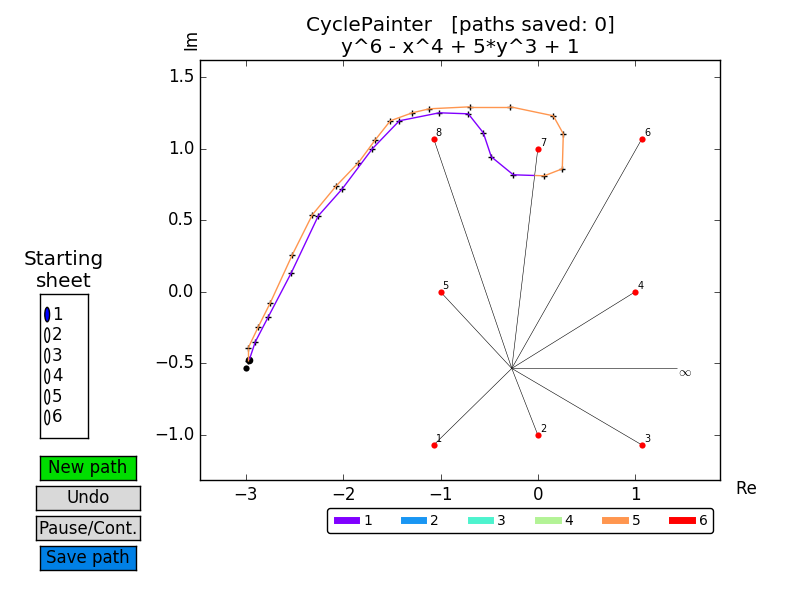

In [156]:
cp.start()

In [137]:
cp.branch_points

[-1.070347571464037? - 1.070347571464037?*I,
 -1*I,
 1.070347571464037? - 1.070347571464037?*I,
 1,
 -1,
 1.070347571464037? + 1.070347571464037?*I,
 1*I,
 -1.070347571464037? + 1.070347571464037?*I,
 +Infinity]

In [125]:
cp.path_segments.get_segments()

[]

In [126]:
cp.current_path

[]

In [149]:
p = cp.rs._path_factory.monodromy_path(cp.rs.branch_points[2])

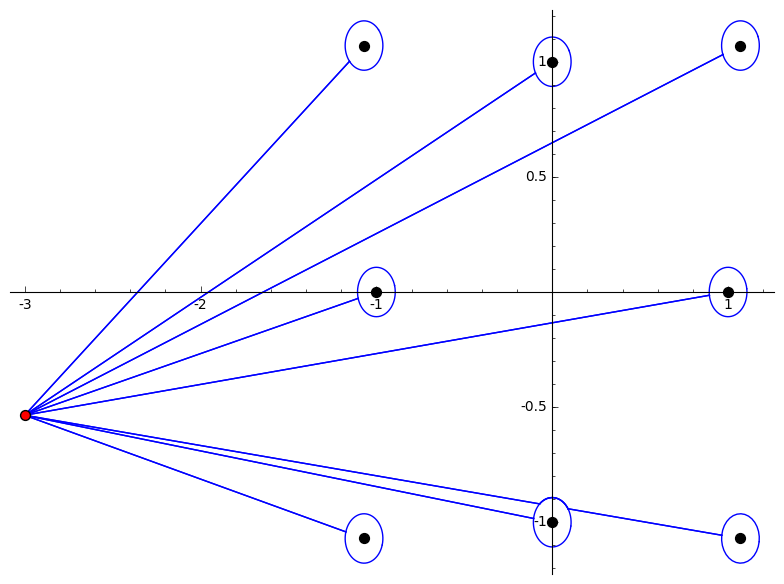

In [155]:
cp.rs.show_paths()